# Attention Is All You Need

In December of 2016, Google Brains team came up with a new way to model sequences called Transformers presented in their paper <a href=https://arxiv.org/abs/1706.03762>Attention is all you need</a>. The impact of this paper continues as most Language models use this approach including some of the industry favorites like BERT and GPT-2.

Below is the basic architecture of the model presented in the paper, and the one we will try implementing.

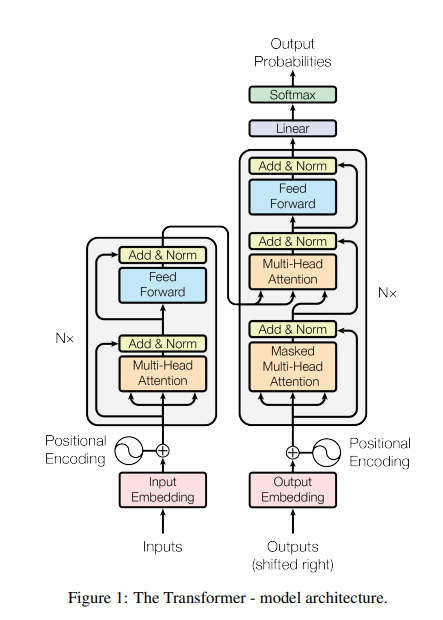

# Introduction

Until now the dominant model design has been based on RNN’s and CNN’s where model has an encoder followed by a decoder. Some models also use attention layers in between. The problem with these approaches is that they often compress the information available into a context vector along with attention vector. This method can very ineffective for long range sequences. Below is a table showing the differences between some of the language modeling approch. Source: <a href= https://deepmind.com/learning-resources/deep-learning-lecture-series-2020>DeepMind</a>

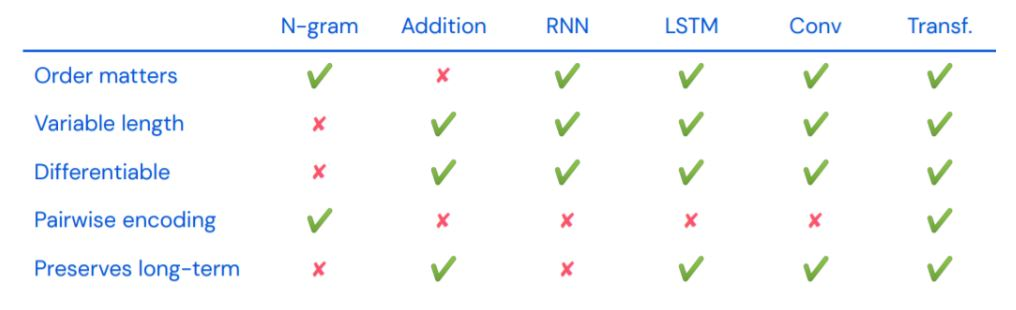

# Data Preperation

In [1]:
# import packages needed
import torch
import torch.nn as nn

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import numpy as np
import spacy

import random
import math
import time

In [2]:
# Set random SEED to make the results reproducable
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We will use spacy for tokenizer, before the exectuion of below line make sure to download the NLP packages using command line.
```shell
python -m spacy download de_core_news_sm
python -m spacy downlaod en_core_web_sm
```

In [3]:
spacy_de = spacy.load("de_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")

In [4]:
def tokenize_de(sen:str)->list:
    """
    Tokenize the sentence and return a list.
    """
    return [tok.text for tok in spacy_de.tokenizer(sen)]

def tokenize_en(sen:str)->list:
    """
    Tokenize the sentence and return a list.
    """
    return [tok.text for tok in spacy_en.tokenizer(sen)]

<b>Note:</b> We wont be doing any stop word removel or n-gram building as we want our model to learn using all the elements in the language.

In [5]:
TRG = Field(tokenize=tokenize_de,
           init_token="<sos>",
           eos_token="<eos>",
           lower=True,
           batch_first=True)

SRC = Field(tokenize=tokenize_en,
           init_token="<sos>",
           eos_token="<eos>",
           lower=True,
           batch_first=True)

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts=(".de", ".en"),
                                                    fields=(TRG, SRC))

In [7]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(datasets=(train_data, valid_data, test_data),
                                                                      batch_size=BATCH_SIZE,
                                                                      device=device)

In [9]:
print("Sample Data")
print("SRC: "," ".join(vars(train_data.examples[0])['src']))
print("TRG: "," ".join(vars(train_data.examples[0])['trg']))

Sample Data
SRC:  zwei junge weiße männer sind im freien in der nähe vieler büsche .
TRG:  two young , white males are outside near many bushes .


# Building the Model

We will build our model in 3 parts <b>Encoder</b>, <b>Decoder</b> and <b>Attention</b>. Finally we will put all of them together into a single <b>Seq2Seq</b> Model.

## Encoder

The encoder is composed of a stack of N = 6 identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, positionwise fully connected feed-forward network. We employ a residual connection around each of
the two sub-layers, followed by layer normalization. That is, the output of each sub-layer is
LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension dmodel = 512.

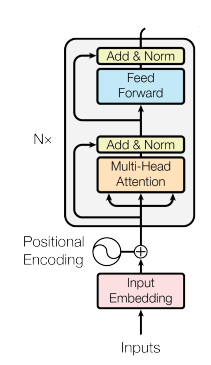

The input tokens pass through the token embedding layer and as the model does not use a recurrent layer it uses the positional embeddings to get the positional information on the tokens, these two are added together. The positional embedding layer does not concerns with the tokens but the position of the token. We have defined a max length of 100 tokens for these embedding layers.

The results from token embeddings and postional embeddings are summed elementwise and the resulting vector is then scaled $\sqrt(d$<sub>model</sub>$)$. where <i>d<sub>model</sub></i> is the hidden dimension of the model. The scaling is done to reduce the variance in the embedding vector as it makes it diffcult for model to train. The dropout is applied on the final embedding vector.

The embedding vector is applied through N encoding layers to get the final context vector which is used by the decoder. The src_mask is similar to src vector, it contains 1 when token is not $<pad>$ and 0 otherwise, this is done to avoid attention layer from focusing on the token.

In [29]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim:int,
                 hid_dim:int,
                 n_layers:int,
                 n_heads:int,
                 pf_dim:int,
                 dropout:float,
                 device:torch.device,
                 max_len=100, **kwargs)->None:
        super().__init__(**kwargs)
        self.device = device
        
        self.tok_embeddings = nn.Embedding(input_dim, hid_dim)
        self.pos_embeddings = nn.Embedding(max_len, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, pf_dim, n_heads, dropout, device) for _ in range(n_layers)])
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(src:torch.tensor, src_mask:torch.tensor)->torch.tensor:
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsquezze(0).repeat(batch_size, 1).to(self.device)
        
        src = self.dropout((self.tok_embeddings(src) * self.scale)) + self.pos_embeddings(pos)
        
        for layer in self.layers:
            src = layer(src, src_mask)
        
        return src

### Encoder Layer

The encoder is made of 6 similar encoder layers, so we have absracted the details into a seperate module, this module can then be repeated N times to build the encoder.

Initially the embedding vector is passed through Multi-Head Attention layer and the passed through dropout layer, the result along with residual connection are elementwise summed and passed through layer normalization. The Multi-Head-Attention is passed the source sentence as the <b>key</b>, <b>value</b> and <b>query</b> (more on that later), this is done so that attention network will attend to the source sentence itself, therefore the name Self-Attention.

The resulting vector is then passed through positionwise feedforward network and along then normalization layer along with its residual connection. The results are then passed on to the next layer.

In [25]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim:int,
                 pf_dim:int,
                 n_heads:int,
                 dropout:float,
                 device:torch.device,
                 **kwargs)->None:
        super().__init__(**kwargs)
        
        self.device = device
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionWiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src:torch.tensor, src_mas:torch.tensor)->torch.tensor:
        _src,_ = self.self_attention(src, src, src, src_mask)
        
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        _src = self.positionwise_feedforward(src)
        
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        return src

## Attention

One of the most groudbreaking ideas introduced in the paper is the idea of using self-attention layers to learn long term dependecies in the sequences.

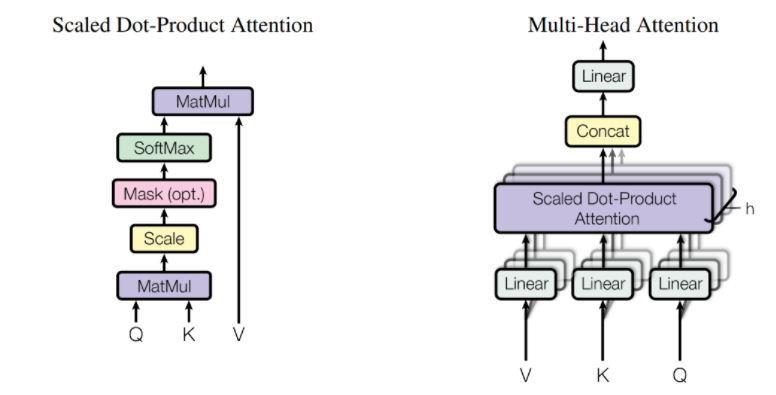

### Single Dot Product Attention

A single attention head takes 3 values a input namely Query(Q), Key(K) and Value(V). One can think of attention as a function which maps given Query to Key-Value pairs, and the corroponding result can be thought of as weighted values that describes which key-value pair is more important to query, the values sum up to 1.

We initially take the dot product of Q and K, which is then scaled to avoid the result becoming to large and making gradient zero. We then take a elementwise product with the mask <i>(optional)</i> to nullify the impact of $<pad>$ token in the final result. Softmax function is then applied on the vector before taking a dot product with V.

\begin{equation*}
Attention(Q, K, V) = Softmax\left(\frac{QK^T} {\sqrt{d_k}}\right)
\end{equation*}

### Multi - Head Attention

Instead of applying Query, Key and values with dimension $d_k$ through a single dot product attention, we divide the dimension up into $h$ components. The computation happens in paralled and the results are then concatenated to get the the final result. This allows the model to learn multiple concepts together rather then focus on a single concept.

One anology that helps me understand this goes like this. Imagine a room consisting of $h$ experts in it, we don't know currently who is expert in which topic, so we pass a question into the room and get the result from each expert with the probability of confidece for each expert. Now initially each expert has equal confindence value assigned for any and every topic. But as we backpropgate and learn over examples, we figure out, which experts answer is more useful for which topic.

For example when I pass a question on cars, each expert provides its advice, but over time, we know whose answer is more useful for this topic, simillarly some other expert can be useful for other topics. In this example, a single dot product attention is an expert, our multi-head attention layer is the room full of experts and our Query, Key and Values are questions we ask.

Now ofcourse this might not be the best example out their but it does help me get a better picture of how things work, feel free to build your own analogies.

\begin{equation*}
Multi - Head Attention(Q, K, V) = Concat\left(head_1, ...., head_h\right)W^O
\end{equation*}
\begin{equation*}
head_i = Attention\left(QW^Q_i,KW^K_i,VW^V_i\right)
\end{equation*}

$W^O$ is the linear layer applied on Q, K and V before being passed onto $h$ attention heads. One strange thing not explained in paper or in the notebook inspiring this work, is why they implemented a dropout layer on the output of the Attention module, as it causes the result to not sum up to 1. Neverthless we have implemented it in our code, as both have done the same, when an answer is found it will be added here.

In [31]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, **kwargs):
        super().__init__(**kwargs)
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim//n_heads
        self.device = device
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.scale = torch.sqrt(torch.FloatTensor(self.head_dim)).to(device)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        v = self.fc_v(value)
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        E = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            E = E.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(E, dim=-1)
        
        X = torch.matmul(self.dropout(attention), V)
        
        X = X.permute(0, 2, 1, 3).contagiuous()
        
        X = X. view(batch_size, -1, self.hid_dim)
        
        X = self.fc_o(X)
        
        return X, attention

## Positionwise Feedforward Layer

The other critical part of encoder decoder is a fully connected feedforward network, which is applied on each position  separately and identically, this consists of two linear transformations of $RELU$ activation in between.

\begin{equation*}
FFN(x) = max\left(0, xW_1 + b_1\right)W_2 + b_2
\end{equation*}

While the linear transformations are the same across different positions, they use different parameters
from layer to layer. Another way of describing this is as two convolutions with kernel size 1.
The original paper implements input and output dimensionallity of $512$ and $ff$ dimension of $2048$

Why is this implemented? Not sure, paper does give a proper answer to the question, if I find will be added here.

In [13]:
class PositionWiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout, **kwargs):
        super().__init__(**kwargs)
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X):
        
        X = self.dropout(torch.relu(self.fc_1(X)))
        
        X = self.fc_2(X)
        
        return X

## Decoder

The task of decoder is to take the encoder vectors from encoder and convert them into predicted tokens $\hat{Y}$. we then compute loss between $\hat{Y}$ and $Y$, which we use to compute gradient and perform backpropogation using our optimizer to update the model weights.

<div>
    <img src="images/Decoder_ATISALUND.JPG" width="300" height="100" />
</div>

Decoder is works similarly as encoder and uses attention mechanism on target tokens instead of source tokens. Except for the part where it has two Multi-Head Attention layers. The first process target embeddings and the next uses encoder output as Key-Value pair and previous layers output as Query.

Before the decoder module, we pass the targets through a standard embedding and perform elementwise sum with positional encoding embeddings, these perform a similar job as in encoder. This has a max length of 100. The result is then passed through N Decoder layers, point to be noted here is that paper never specified that the number of layers in Encoder and Decoder has to be same.

As PyTorch applies softmax during loss calculation, we do not implement that here.

In [38]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_len=100, **kwargs):
        super().__init__(*kwargs)
        
        self.device = device
        
        self.tok_embeddings = nn.Embedding(output_dim, hid_dim)
        self.pos_embeddings = nn.Embedding(max_len, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, batch_size3).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        trg = self.dropout((self.tok_embeddings(trg) * self.scale) + pos_embeddings(pos))
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        output = self.fc_out(trg)
        
        return output, attention

### Decoder Layer

The decoder layer consists of two <i>Multi-Head Attention</i> layers, one <i>self-attention</i> and another <i>encoder attention</i>. The first takes target tokens as Query and Key-Value pairs and performs self attention, while the other takes the out put of <i>self-attention</i> layer as Query and <i>Encoder Output</i> as Key-Value pair.

The first attention module uses target sequence mask, this is done to prevent the model from being able to see the next token in sequence as we process al the tokens in parallel. The second attention layer is feed the self-attention layers output as Query and Encoder Output as Key-Value pair, the module is also provided with src_mask, this is done to prevent the model from paying attention on $<pad>$ tokens.

Both Multi-Head Attention layers are followed by residual connection and Dropout layer which is then feed into a layer normalization module.

THe result is then passed through as PositionWise feedforward network and another set of residual connection and layer normalization module.

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, **kwargs):
        super().__init__(**kwargs)
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.enc_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = nn.Linear(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        
        _trg, attention = self.enc_attention(trg, enc_src, enc_src, src_mask)
        
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        
        _trg = self.positionwise_feedforward(trg)
        
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        return trg, attention

## Seq2Seq Model

Finally we bring everything together in Seq2Seq model which encapsulates our Encoder and Decoder and also create masks for Source tokens and Target tokens. Lets talk about masks.

### Source Mask

Source masks are created to nullify the impact of $<pad>$ tokens on the attention module.This mask is reletivly easy to create, we just check which tokens are $<pad>$ and add a 0 at that position except keep it 1. We can use a boolean operation to get the mask matrix as `src != <pad>`

### Target Mask

The target mask is created for dual reason, one is similar to source mask which is to nullify the impact of $<pad>$ on the attention layer and second is to avoid the decoder from being able to see the next token in sequence as it is being processed in parallel. To achieve this we first create a `trg_mask` similar to `src_mask` to account for $<pad>$ tokens, next we create a sub mask using `torch.trill` which creates a diaginal matrix, where every element above diaginol is zero and rest keep the original value.

$$\begin{bmatrix} 1 & 0 & 0 & 0 \\ 1 & 1 & 0 &  0 \\ 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 1 \end{bmatrix}$$

The the sub mask is combined with `trg_mask` to give the final mask. In below case the last 2 tokens were $<pad>$.

$$\begin{bmatrix} 1 & 0 & 0 & 0 \\ 1 & 1 & 0 &  0 \\ 1 & 1 & 0 & 0 \\ 1 & 1 & 0 & 0 \end{bmatrix}$$

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device, **kwargs):
        super().__init__(**kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        
        trg_mask = trg_pad_mask & trg_sub_mask
        
        return trg_mask
    
    def forward(self, src, trg):
        src_mask = make_src_mask(src)
        trg_mask = make_trg_mask(trg)
        
        enc_src = self.encoder(src, src_mask)
        
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        return output, attention

# Training the Model

Out model will be siginificantly smaller then the one presented in the paper os it can run on my system, and also will train for smaller time.

In [41]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)

dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

Now we can count the number of trainable parameters in the model.

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 9,148,077 trainable parameters
